# ConvLSTM

In [1]:
# %load_ext autoreload
# %autoreload 2
import matplotlib.pyplot as plt
import numpy as np

from ConvLSTM import *

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

figures saved to ../Figures/Modeling/ConvLSTM
figures saved to ../Datasets/fastStorage/images


## Data exploration

In [2]:
# Load data
VM_NUM = 917
VM = load_VM(f'{VM_NUM}.csv')
# VM = load_VM('599.csv')
# Make it univariate
df = VM[['CPU usage [MHZ]']]

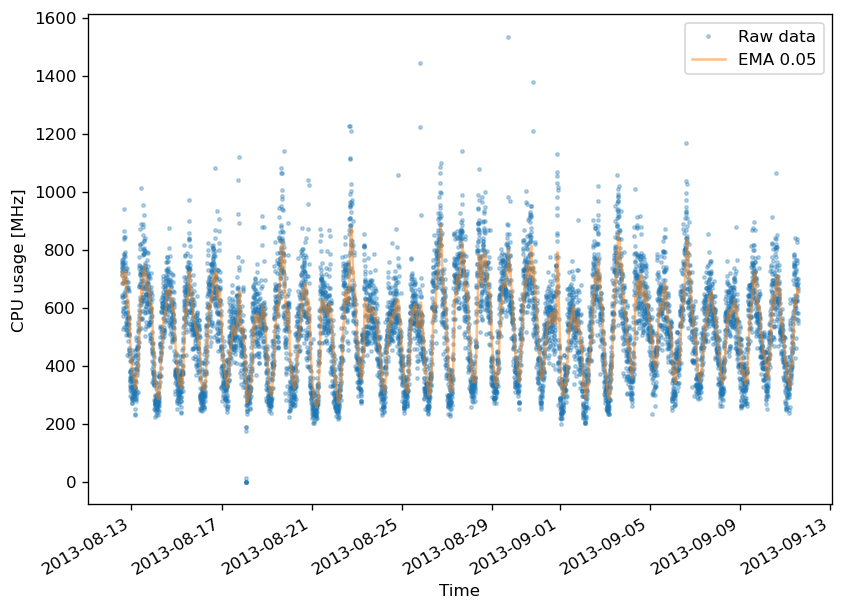

In [3]:
%matplotlib inline
plot_timeSeries(df['CPU usage [MHZ]'], ylabel='CPU usage [MHz]')

## Split the data

In [4]:
# (70%, 20%, 10%) split for the training, validation, and test sets
train_df, val_df, test_df = split_data(df)

## Normalizing the data

In [5]:
scaler = MinMaxScaler()
train_df, val_df, test_df = data_transformation(scaler, train_df, val_df, test_df)

## ConvLSTM

In [21]:
ConvLSTM_model = ConvLSTMModel(input_width=64,
                            label_width=16,
                            df=df,
                            model_name='LRCN',
                            name='917/frames_8',
                            train_df=train_df,
                            val_df=val_df,
                            test_df=test_df,
                            epoch=50,
                            batch_size=16,
                            n_frames=8,
                            model_path='./logs/ConvLSTM/LRCN/917/frames_8/checkpoints/ConvLSTM_model_2022_03_30__13_57_33.hdf5',
                            numeric=True,
                            # overlapping=0.9
                            )

figures saved to ../Figures/Modeling/ConvLSTM
figures saved to ../Datasets/fastStorage/images


In [22]:
input, labels = ConvLSTM_model.train

### Data Visualization

Displaying frames for example 102.


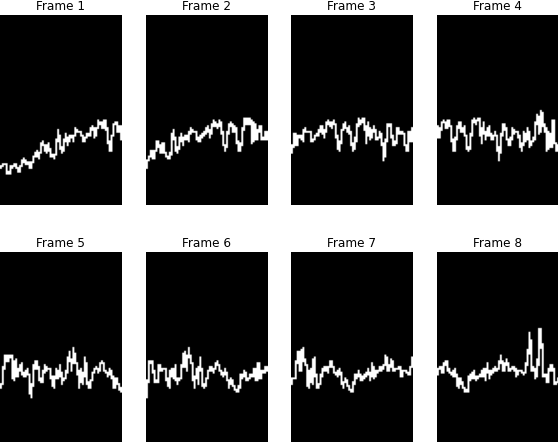

In [23]:
%matplotlib inline
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 4, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(input)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(input[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

Displaying frames for example 348.


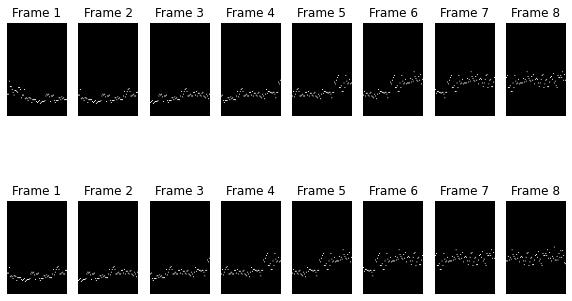

In [9]:
%matplotlib inline
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 8, figsize=(10, 6))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(input)), size=1)[0]
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(input[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(labels[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

### Training

In [ ]:
history = ConvLSTM_model.compile_and_fit()

In [12]:
# Load model
# Load model
if ConvLSTM_model.model_path is not None:
    ConvLSTM_model.model = tf.keras.models.load_model(ConvLSTM_model.model_path)
else:
    ConvLSTM_model.model = get_model(ConvLSTM_model, ConvLSTM_model.model_name)

In [13]:
# Predict
pred, pred_df_trf = ConvLSTM_model.prediction(scaler)

Inference:


2022-03-30 19:00:28.479544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-30 19:00:28.550842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Inference time: 0.46 sec
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0538

2022-03-30 19:00:28.886538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-30 19:00:28.967699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - mean_absolute_error: 0.0458


In [28]:
test_df =test_df.reset_index()

In [31]:
metrics = ConvLSTM_model.evaluation(pred_df_trf, scaler)

                            0
MAE                 74.218063
MAPE                15.059402
RMSE                92.619591
MASE                 1.253374
train_time [s]       0.000000
inference_time [s]   1.514932
model_size [B]       0.000000
              MAE        MAPE        RMSE
count  848.000000  848.000000  848.000000
mean    74.218054   15.059402   74.218054
std     55.440908   11.488126   55.440908
min      0.422038    0.068394    0.422038
25%     28.814576    5.753171   28.814576
50%     62.203267   12.333882   62.203267
75%    110.091827   22.338521  110.091827
max    425.410662   68.558369  425.410662


              MAE        MAPE        RMSE
count  848.000000  848.000000  848.000000
mean   139.926032   30.362664  139.926032
std     94.126915   23.900411   94.126915
min      0.086667    0.017123    0.086667
25%     66.169974   11.755254   66.169974
50%    131.126616   25.612148  131.126616
75%    194.024925   42.170730  194.024925
max    537.679723  134.795918  537.679723


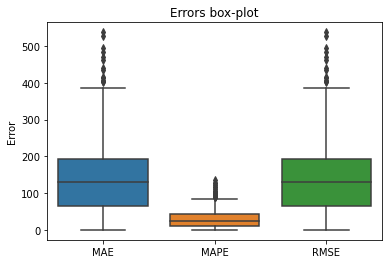

In [9]:
errors = ConvLSTM_model.errors_boxplot(pred_df_trf, scaler)

In [23]:
errors.describe()

figures saved to ../Figures/Modeling/ConvLSTM
figures saved to ../Datasets/fastStorage/images


,MAE,MAPE,RMSE
count,848.000000,848.000000,848.000000
mean,86.967614,17.204596,86.967614
std,67.210085,12.837112,67.210085
min,0.086667,0.017123,0.086667
25%,35.381653,7.343138,35.381653
50%,72.366617,14.317482,72.366617
75%,120.899953,24.969458,120.899953
max,407.246508,69.966887,407.246508


In [14]:
%matplotlib tk
# Test_pred dataset
input = ConvLSTM_model.test_pred[0]
label = ConvLSTM_model.test_pred[1]
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(4, 5, figsize=(20, 20))
# Plot the original frames.
axes[0][2].set_title('Input')
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(input[idx]), cmap="gray")
    # ax.set_title(f"Sample {idx}")
    ax.axis("off")
# Plot the new frames.
axes[1][2].set_title('Labels')
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(label[idx]), cmap="gray")
    # ax.set_title(f"Sample {idx}")
    ax.axis("off")
axes[2][2].set_title('Output')
# Prediction
for idx, ax in enumerate(axes[2]):
    ax.imshow(np.squeeze(pred[idx]), cmap="gray")
    # ax.set_title(f"Sample {idx}")
    ax.axis("off")
# Prediction binarize
axes[3][2].set_title('Output binarized')
for idx, ax in enumerate(axes[3]):
    ax.imshow(np.squeeze(ConvLSTM_model.binarize_image(pred[idx])), cmap="gray")
    # ax.set_title(f"Sample {idx}")
    ax.axis("off")

In [29]:
# Figure for forecasting part of image
img_input = ConvLSTM_model.extract_forecast_from_image(ConvLSTM_model.test_pred[0])
img_label = ConvLSTM_model.extract_forecast_from_image(ConvLSTM_model.test_pred[1])
# Binarize the image
# img_pred_bin = ConvLSTM_model.binarize_image(img_pred)
fig, axes = plt.subplots(3, 1, figsize=(15, 6))
plt.suptitle('Test set: GT vs prediction', fontsize=16)
# Ground Truth
axes[0].imshow(img_input, cmap="gray")
axes[0].set_title('Input')
axes[0].axis("off")
# Prediction
axes[1].imshow(img_label, cmap="gray")
axes[1].set_title('Label')
axes[1].axis("off")
# Prediction
axes[2].imshow(img_pred, cmap="gray")
axes[2].set_title('Prediction')
axes[2].axis("off")


(-0.5, 831.5, 99.5, -0.5)

In [13]:
%matplotlib tk
# Figure of raw output
# Ground truth
gt = ConvLSTM_model.test_pred[1]
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 5, figsize=(20, 4))
# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(gt[idx]), cmap="gray")
    ax.set_title(f"Sample {idx}")
    ax.axis("off")
# Plot the new frames.
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(ConvLSTM_model.binarize_image(pred[idx])), cmap="gray")
    ax.set_title(f"Sample {idx}")
    ax.axis("off")
plt.show()

In [13]:
aux = pred[0,...]
aux = np.squeeze(aux)

In [26]:
%matplotlib tk
# Figure forecast
# Define default kwargs
defaultKwargs = {'marker': 'o',
                 'linestyle': '-',
                 'alpha': 0.3,
                 'markersize': 2}
kwargs_forecast = {'marker': 'o',
                   'linestyle': '-',
                   'alpha': 0.5,
                   'markersize': 2,
                   'color': 'tab:orange'}
fig = plt.figure(dpi=200)
plt.grid()
ConvLSTM_model.df['CPU usage [MHZ]'].plot(label='actual', color='k', **defaultKwargs)
pred_df_trf['CPU usage [MHZ]'].plot(label='forecast', **kwargs_forecast)
plt.ylabel('CPU usage [MHz]')
plt.title(f'Actual vs Forecast')
plt.grid()
plt.legend()
plt.show()

In [15]:
# Test set
test_trf = scaler.inverse_transform(ConvLSTM_model.test_df)
test_df_trf = pd.DataFrame(data=test_trf, columns=ConvLSTM_model.test_df.columns, index=ConvLSTM_model.test_df.index)
# Figure zoom
fig = plt.figure(dpi=200)
plt.grid()
test_df_trf['CPU usage [MHZ]'].plot(label='actual', color='k', **defaultKwargs)
pred_df_trf['CPU usage [MHZ]'].shift(periods=-16).plot(label='forecast', **kwargs_forecast)
plt.ylabel('CPU usage [MHz]')
plt.title(f'Actual vs Forecast (Zoom)')
plt.grid()
plt.legend()

In [28]:
 # Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 1, figsize=(20, 7), sharex=True, sharey=True)
plt.suptitle('Test set: GT vs prediction', fontsize=16)
# Ground Truth
axes[0].plot(test_df_trf['CPU usage [MHZ]'],label='actual', color='k', **defaultKwargs)
axes[0].set_title('Ground truth')
axes[0].set_ylabel('CPU usage [MHz]')
# Prediction
axes[1].plot(pred_df_trf['CPU usage [MHZ]'], label='forecast', **kwargs_forecast)
axes[1].set_title('Prediction')
axes[1].set_ylabel('CPU usage [MHz]')
axes[1].set_xlabel('Time')

Text(0.5, 0, 'Time')

In [29]:
 # Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 1, figsize=(20, 7), sharex=True, sharey=True)
plt.suptitle('Test set: GT vs prediction', fontsize=16)
# Ground Truth
axes[0].plot(df['CPU usage [MHZ]'],label='actual', color='k', **defaultKwargs)
axes[0].set_title('Ground truth')
axes[0].set_ylabel('CPU usage [MHz]')
# Prediction
axes[1].plot(pred_df_trf['CPU usage [MHZ]'], label='forecast', **kwargs_forecast)
axes[1].set_title('Prediction')
axes[1].set_ylabel('CPU usage [MHz]')
axes[1].set_xlabel('Time')

Text(0.5, 0, 'Time')

# Playground

In [22]:
ConvLSTM_model.create_image_dataset(train_df, os.path.join(DATASET_PATH,'917','train') )

In [ ]:
img = cv2.imread('../Datasets/fastStorage/images/917/train/train_1.png', cv2.IMREAD_GRAYSCALE)

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 128, 128
# Resize the Frame to fixed height and width.
resized_img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
# Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
normalized_img = resized_img / 255

In [ ]:
cv2.imshow('Image',normalized_img)
cv2.waitKey(0)

In [9]:
%matplotlib tk
# Get numpy image from matplotlib from buffer (without saving)
fig = full_frame(figsize, dpi)
# set y-axis limits
plt.plot(train_df.iloc[:80,:], ',', color='black')
plt.ylim(0,1)
buf = io.BytesIO()
plt.savefig(buf, format="png", dpi=dpi)
buf.seek(0)
img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
buf.close()
img = cv2.imdecode(img_arr, cv2.IMREAD_GRAYSCALE)

In [10]:
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [12]:
y_train = ConvLSTM_model.train[1]
y_train = y_train[0,0,...]
y_train = np.squeeze(y_train)

## Image with numpy

In [6]:
# Create image using numpy
data = np.array(train_df.iloc[:80,:]).squeeze()

In [7]:
# Get the height of each column (0-100)
level = np.round(data*100)
# Invert y-axis from bottom to top
level = 100 - level

In [8]:
WIDTH = 64
HEIGHT = 100
img = np.zeros((HEIGHT, WIDTH))
# Fill with ones the corresponding level
for i in range(img.shape[1]):
    img[int(level[i]),i] = 255

In [9]:
cv2.imshow('Image', img)
cv2.waitKey(0)

27

In [10]:
save_path = os.path.join(FIGURES_PATH, 'ConvLSTM', 'Sample.png')
cv2.imwrite(save_path, img)

True

## Image matplotlib

In [7]:
# Create image using numpy
data = np.array(train_df.iloc[:64,:]).squeeze()

In [17]:
img = ConvLSTM_model.create_image_matplotlib(data, 64)

figures saved to ../Figures/Modeling/ConvLSTM
figures saved to ../Datasets/fastStorage/images


In [18]:
cv2.imshow('Image', img)
cv2.waitKey(0)

27

## Recurrence plot

In [60]:
from pyts.image import RecurrencePlot, GramianAngularField

In [58]:
# Create image using numpy
data = np.array(train_df.iloc[:64,:].squeeze())
x = np.array([data])
rp = RecurrencePlot()
X_rp = rp.transform(x)

In [59]:
%matplotlib tk
plt.imshow(X_rp[0], cmap='binary', origin='lower')

## Gramian angular field

In [62]:
gasf = GramianAngularField(method='summation')
X_gasf = gasf.fit_transform(x)

In [65]:
plt.imshow(X_gasf[0], cmap='rainbow', origin='lower')

In [ ]:
cv2.destroyAllWindows()
cv2.waitKey(-1)

## Create synthetic dataset

In [ ]:
def synthetic_dataset_black(df, freq):
    time = np.arange(0, len(df))
    amplitude = np.sin(2*np.pi*freq*time)
    amplitude[0] = -4
    amplitude[len(df)-1] = 4
    df['CPU usage [MHZ]'] = amplitude
    return df

In [7]:
%matplotlib tk
freq= 1/288
time = np.arange(0, len(df))
amplitude = np.sin(2*np.pi*freq*time)
plt.plot(amplitude)

In [11]:
new_df = df.copy()

In [12]:
new_df = synthetic_dataset_black(new_df, 1/25)

<AxesSubplot:xlabel='Timestamp [ms]'>

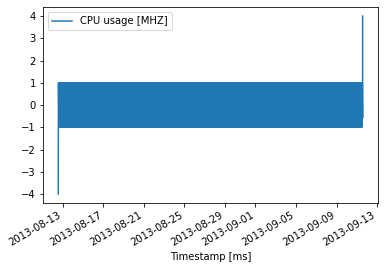

In [13]:
new_df.plot()

In [23]:
df.plot()

<AxesSubplot:xlabel='Timestamp [ms]'>